<a href="https://colab.research.google.com/github/neel-shel/U-Net-with-contoured-inmages/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [ ]:
import cv2
import random
from skimage.io import imread,imshow
from scipy.linalg import norm
from scipy import sum, average
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.transform import resize
import cv2
from tqdm.notebook import tqdm

## **DO NOT CHANGE THIS CELL**

### Training hyper-params

In [ ]:
total_epochs = 10
batch_size = 32
smooth=100

### Image resolution

In [ ]:
img_width=128
img_height=128
img_channels=3

### Seed

In [ ]:
seed=40
np.random.seed=seed
np.random.seed=seed

### **Mount Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Preprocessing**

In [ ]:
TRAIN_PATH='/content/drive/MyDrive/data-science-bowl-2018/stage1_train/'
TEST_PATH='/content/drive/MyDrive/data-science-bowl-2018/stage1_test/'

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train=np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8)
Y_train=np.zeros((len(train_ids),img_height,img_width,1),dtype=np.bool_)
X_test=np.zeros((len(test_ids),img_height,img_width,img_channels),dtype=np.uint8)
Y_test=np.zeros((len(test_ids),img_height,img_width,1),dtype=np.bool_)

In [ ]:
print('Resizing training images')
for n, id in tqdm(enumerate(train_ids),total=len(train_ids)):
  path=TRAIN_PATH+id
  if id=='.ipynb_checkpoints':
    break
  img=imread(path+'/images/'+id+'.png')
  img=resize(img,(img_height,img_width,img_channels),mode='constant',preserve_range=True)[:,:,:img_channels]
  X_train[n]=img
  mask=np.zeros((img_height,img_width,1),dtype=np.bool_)
  for mask_file in next(os.walk(path+'/masks/'))[2]:
    mask_=imread(path+'/masks/'+mask_file)
    mask_=np.expand_dims(resize(mask_,(img_height,img_width),mode='constant',preserve_range=True),axis=-1)
    mask=np.maximum(mask_,mask)
  Y_train[n]=mask

Resizing training images


  0%|          | 0/670 [00:00<?, ?it/s]

In [ ]:
print('Resizing testing images')
for n, id in tqdm(enumerate(test_ids),total=len(test_ids)):
  path=TEST_PATH+id
  img=imread(path+'/images/'+id+'.png')
  img=resize(img,(img_height,img_width,img_channels),mode='constant',preserve_range=True)[:,:,:img_channels]
  X_test[n]=img

# **Output metrics**

In [ ]:
def pixel_error(img1, img2):
    # calculate the difference and its norms
    img1=K.flatten(img1)
    img2=K.flatten(img2)
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = K.sum(K.abs(diff))  # Manhattan norm
    z_norm = norm(tf.experimental.numpy.ravel(diff), 0)  # Zero norm
    return (m_norm/img1.size(), z_norm/img1.size())

## **Dice Coefficient**

In [ ]:
def dice_coef(y_true, y_pred):
    """
    Function to calculate dice coefficient

    Parameters
    ----------
    y_true : numpy array of actual masks
    y_pred : numpy array of predicted masks

    Returns
    -------
    dice coefficient

    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

## **Jaccard Distance Loss**

In [ ]:
def jaccard_distance_loss(y_true, y_pred, smooth=smooth):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

## **Intersection of Union**

In [ ]:
def IOU(y_true, y_pred):
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    true_pixels=K.flatten(true_pixels)
    pred_pixels=K.flatten(pred_pixels)
    true_labels = K.equal(true_pixels, 0) # target label
    pred_labels = K.equal(pred_pixels, 0) # target label
    inter = tf.cast(true_labels & pred_labels,tf.float32)
    union = tf.cast(true_labels | pred_labels,tf.float32)
    iou = K.sum(inter)/K.sum(union)
    return iou

### **Plot function**

In [ ]:
def plot_model_history(history):
    """
    Function to plot training and validation data of model

    Parameters
    ----------
    history: dictionary
             history of training and validation of model
    Returns
    -------
    None

    """
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice coefficient')
    plt.ylabel('dice_coefficient')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0,50)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for jaccard_distance_loss
    plt.plot(history.history['jaccard_distance_loss'])
    plt.plot(history.history['val_jaccard_distance_loss'])
    plt.title('model jaccard_distance_loss')
    plt.ylabel('jaccard_distance_loss')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for IOU
    plt.plot(history.history['IOU'])
    plt.plot(history.history['val_IOU'])
    plt.title('model IOU')
    plt.ylabel('IOU')
    plt.xlabel('epoch')
    plt.ylim(0,2)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# **Architecture**

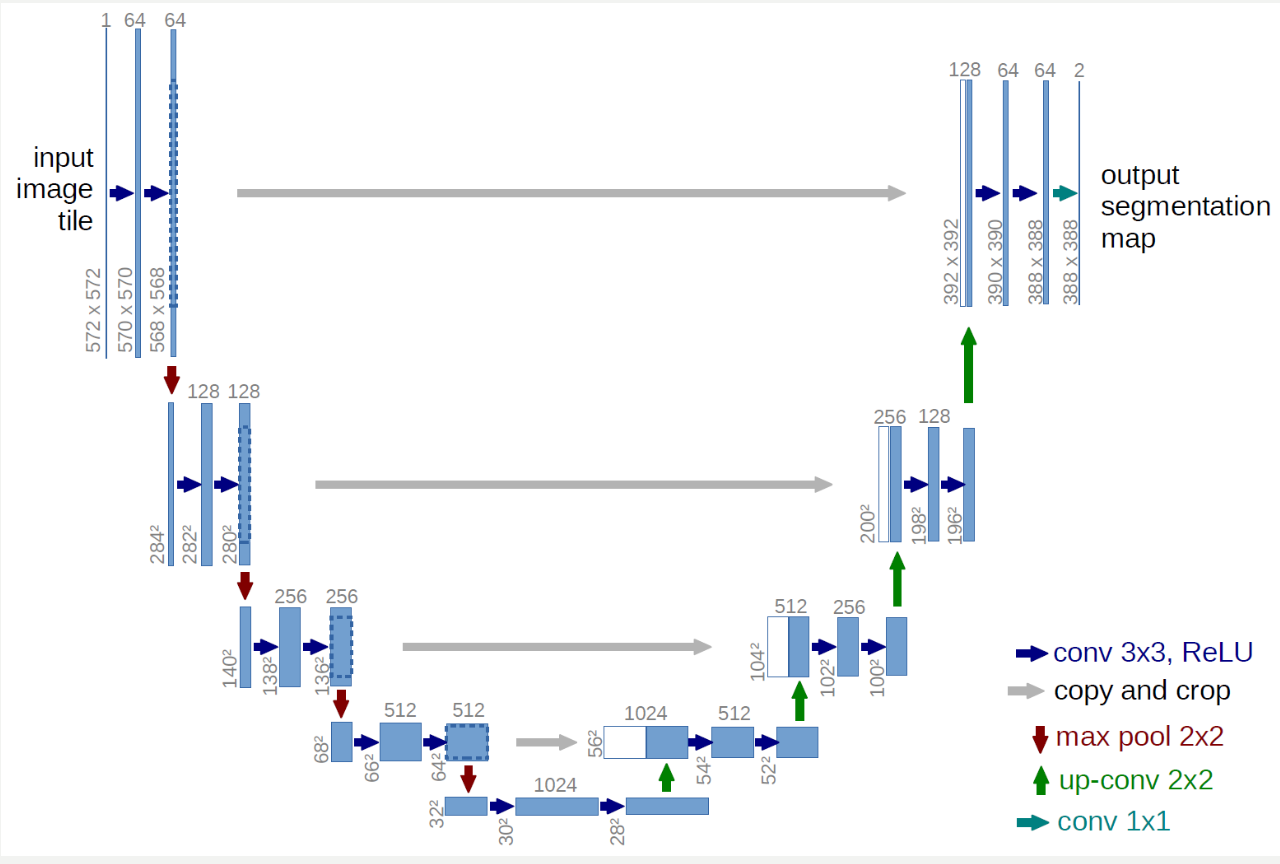

In [ ]:
inputs = tf.keras.layers.Input((img_height, img_width, img_channels))
inputs=tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[jaccard_distance_loss,dice_coef,IOU,'accuracy'])
model.summary()

# **Training**

---



In [ ]:
#checkpoint
checkpoint=tf.keras.callbacks.ModelCheckpoint("modelForNuclei.h5", verbose=1, save_best_only=True)
#Callbacks

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(X_train)
Callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir='log'),
    checkpoint

]
results=model.fit(X_train,Y_train,validation_split=0.01,shuffle=True,callbacks=Callbacks,epochs=total_epochs,batch_size=batch_size)

In [ ]:
Y_train=Y_train.astype(np.uint8)

# **Results**

### **Plots**

In [ ]:
plot_model_history(results)

**Sanity check**

In [ ]:
idx=random.randint(0,len(X_train))
pred_train=model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
pred_val=model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
pred_test=model.predict(X_test,verbose=1)

In [ ]:
pred_train_t=(pred_train>0.5).astype(np.uint8)
pred_test_t=(pred_test>0.5).astype(np.uint8)
pred_val_t=(pred_val>0.5).astype(np.uint8)

In [ ]:
ix=random.randint(0,len(pred_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [ ]:
ix=random.randint(0,len(pred_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(pred_val_t[ix]))
plt.show()

In [ ]:
ix=random.randint(0,len(pred_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(pred_test_t[ix]))
plt.show()

# **Contour Based CE Loss**

## **Countours Example**

In [ ]:
from google.colab.patches import cv2_imshow
# Read the color image
image = cv2.imread('/content/WhatsApp Image 2022-07-16 at 1.21.26 PM.jpeg')

# Make a copy
new_image = image.copy()

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
cv2_imshow(gray)
cv2.waitKey(0) # Wait for keypress to continue
cv2.destroyAllWindows() # Close windows

# Convert the grayscale image to binary
ret, binary = cv2.threshold(gray, 100, 255,
  cv2.THRESH_OTSU)


# Display the binary image
cv2_imshow(binary)
cv2.waitKey(0) # Wait for keypress to continue
cv2.destroyAllWindows() # Close windows

# To detect object contours, we want a black background and a white
# foreground, so we invert the image (i.e. 255 - pixel value)
inverted_binary = ~binary
cv2_imshow(inverted_binary)
cv2.waitKey(0) # Wait for keypress to continue
cv2.destroyAllWindows() # Close windows

# Find the contours on the inverted binary image, and store them in a list
# Contours are drawn around white blobs.
# hierarchy variable contains info on the relationship between the contours
contours, hierarchy = cv2.findContours(inverted_binary,
  cv2.RETR_TREE,
  cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours (in red) on the original image and display the result
# Input color code is in BGR (blue, green, red) format
# -1 means to draw all contours
with_contours = cv2.drawContours(image, contours, -1,(255,0,255),3)
cv2_imshow(with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Show the total number of contours that were detected
print('Total number of contours detected: ' + str(len(contours)))

# Draw just the first contour
# The 0 means to draw the first contour
first_contour = cv2.drawContours(new_image, contours, 0,(255,0,255),3)
cv2_imshow(first_contour)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Draw a bounding box around the first contour
# x is the starting x coordinate of the bounding box
# y is the starting y coordinate of the bounding box
# w is the width of the bounding box
# h is the height of the bounding box
x, y, w, h = cv2.boundingRect(contours[0])
cv2.rectangle(first_contour,(x,y), (x+w,y+h), (255,0,0), 5)
cv2_imshow(first_contour)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Draw a bounding box around all contours
for c in contours:
    # Make sure contour area is large enough
  if (cv2.contourArea(c)) > 50:
    cv2.rectangle(with_contours,(x,y), (x+w,y+h), (255,0,0), 5)

cv2_imshow(with_contours)
cv2.waitKey(0)
cv2.destroyAllWindows()

# **Preprocessing**

In [ ]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train=np.zeros((len(train_ids),img_height,img_width,img_channels),dtype=np.uint8)
Y_train=np.zeros((len(train_ids),img_height,img_width,1),dtype=np.bool_)
X_test=np.zeros((len(test_ids),img_height,img_width,img_channels),dtype=np.uint8)
Y_test=np.zeros((len(test_ids),img_height,img_width,1),dtype=np.bool_)

In [ ]:
print('Resizing training images')
for n, id in tqdm(enumerate(train_ids),total=len(train_ids)):
  path=TRAIN_PATH+id
  if id=='.ipynb_checkpoints':
    break
  image = cv2.imread(path+'/images/'+id+'.png')

  # Make a copy
  new_image = image.copy()
  cv2.imwrite(path+id+'.tif',new_image)
  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


  # Convert the grayscale image to binary
  ret, binary = cv2.threshold(gray, 100, 255,
    cv2.THRESH_OTSU)




  # To detect object contours, we want a black background and a white
  # foreground, so we invert the image (i.e. 255 - pixel value)
  inverted_binary = ~binary

  # Find the contours on the inverted binary image, and store them in a list
  # Contours are drawn around white blobs.
  # hierarchy variable contains info on the relationship between the contours
  contours, hierarchy = cv2.findContours(inverted_binary,
    cv2.RETR_TREE,
    cv2.CHAIN_APPROX_SIMPLE)

  # Draw the contours (in red) on the original image and display the result
  # Input color code is in BGR (blue, green, red) format
  # -1 means to draw all contours
  with_contours = cv2.drawContours(image, contours, -1,(255,0,255),4)

  # Show the total number of contours that were detected
  print('Total number of contours detected: ' + str(len(contours)))

  # Draw just the first contour
  # The 0 means to draw the first contour
  first_contour = cv2.drawContours(new_image, contours, 0,(255,0,255),3)

  # Draw a bounding box around the first contour
  # x is the starting x coordinate of the bounding box
  # y is the starting y coordinate of the bounding box
  # w is the width of the bounding box
  # h is the height of the bounding box
  x, y, w, h = cv2.boundingRect(contours[0])
  cv2.rectangle(first_contour,(x,y), (x+w,y+h), (255,0,0), 5)

  # Draw a bounding box around all contours
  for c in contours:
      # Make sure contour area is large enough
    if (cv2.contourArea(c)) > 5:
      cv2.rectangle(with_contours,(x,y), (x+w,y+h), (255,0,0), 5)
  img=resize(with_contours,(img_height,img_width,img_channels),mode='constant',preserve_range=True)[:,:,:img_channels]
  X_train[n]=img
  mask=np.zeros((img_height,img_width,1),dtype=np.bool_)
  for mask_file in next(os.walk(path+'/masks/'))[2]:
    mask_=imread(path+'/masks/'+mask_file)
    mask_=np.expand_dims(resize(mask_,(img_height,img_width),mode='constant',preserve_range=True),axis=-1)
    mask=np.maximum(mask_,mask)
  Y_train[n]=mask

In [ ]:
print('Resizing testing images')
for n, id in tqdm(enumerate(test_ids),total=len(test_ids)):
  path=TEST_PATH+id
  img=cv2.imread(path+'/images/'+id+'.png')
  new_image=img.copy()
  # Convert the image to grayscale
  gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

  # Convert the grayscale image to binary
  ret, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_OTSU)

  # To detect object contours, we want a black background and a white
  # foreground, so we invert the image (i.e. 255 - pixel value)
  inverted_binary = ~binary

  # Find the contours on the inverted binary image, and store them in a list
  # Contours are drawn around white blobs.
  # hierarchy variable contains info on the relationship between the contours
  contours, hierarchy = cv2.findContours(inverted_binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  x, y, w, h = cv2.boundingRect(contours[0])
  # Draw the contours (in red) on the original image and display the result
  # Input color code is in BGR (blue, green, red) format
  # -1 means to draw all contours
  with_contours = cv2.drawContours(new_image, contours, -1,(255,0,255),4)
  # Draw a bounding box around all contours
  for c in contours:
      # Make sure contour area is large enough
    if (cv2.contourArea(c)) > 5:
      cv2.rectangle(with_contours,(x,y), (x+w,y+h), (255,0,0), 5)
  img=resize(with_contours,(img_height,img_width,img_channels),mode='constant',preserve_range=True)[:,:,:img_channels]

  X_test[n]=img

# **Architecture**

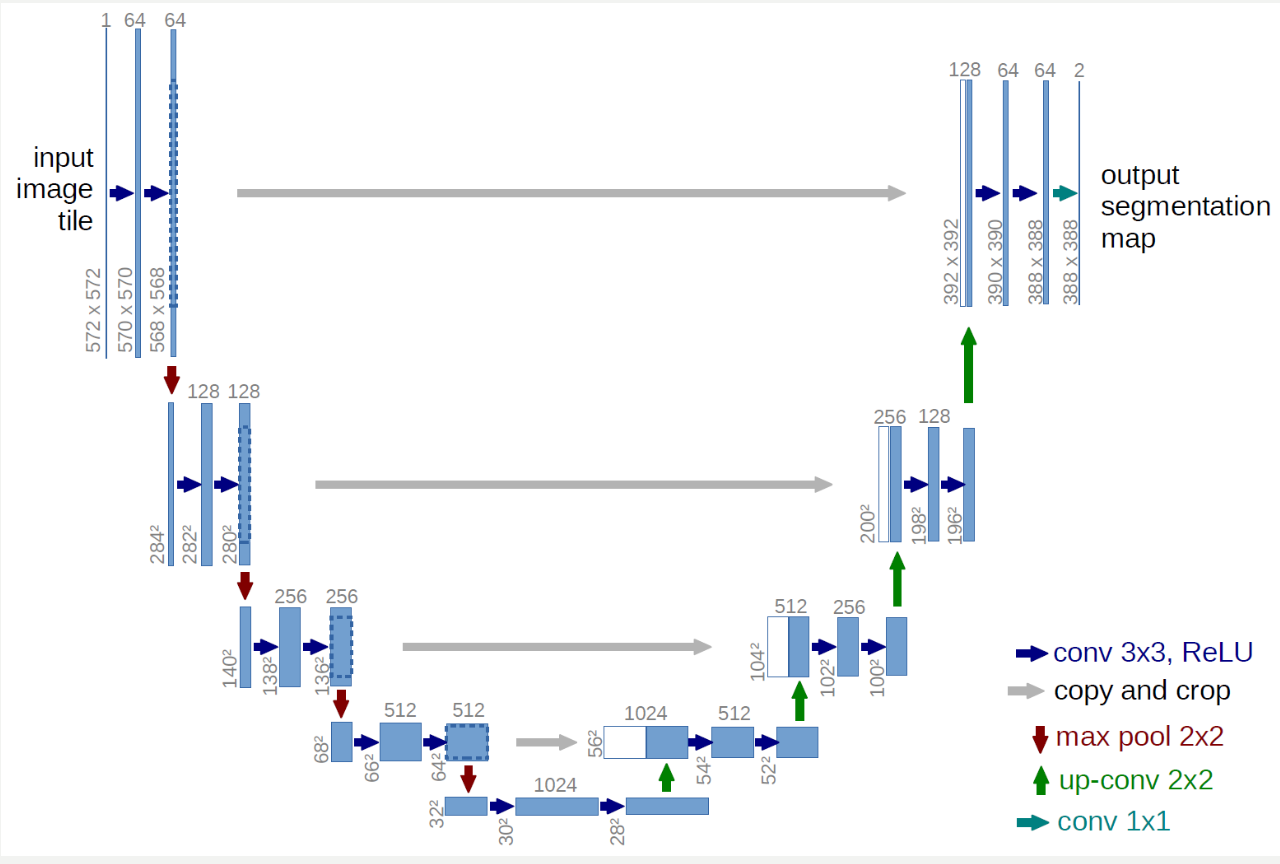

In [ ]:
inputs = tf.keras.layers.Input((img_height, img_width, img_channels))
inputs=tf.keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,beta_initializer="zeros",gamma_initializer="ones",moving_mean_initializer="zeros",moving_variance_initializer="ones",beta_regularizer=None,gamma_regularizer=None,beta_constraint=None,gamma_constraint=None)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=['binary_crossentropy'], metrics=[jaccard_distance_loss,dice_coef,IOU,'accuracy'])
model.summary()

# **Training**

In [ ]:
#checkpoint
checkpoint=tf.keras.callbacks.ModelCheckpoint("modelForNuclei.h5", verbose=1, save_best_only=True)
#Callbacks

Callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir='log'),
    checkpoint

]
results=model.fit(X_train,Y_train,validation_split=0.01,shuffle=True,epochs=total_epochs,batch_size=batch_size,callbacks=Callbacks)

In [ ]:
Y_train=Y_train.astype(np.uint8)

# **Results**

### **Plots**

In [ ]:
plot_model_history(results)

### **Sanity check**

In [ ]:
pred_train_t=(pred_train>0.5).astype(np.uint8)
pred_test_t=(pred_test>0.5).astype(np.uint8)
pred_val_t=(pred_val>0.5).astype(np.uint8)

In [ ]:
ix=random.randint(0,len(pred_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(pred_train_t[ix]))
plt.show()

In [ ]:
ix=random.randint(0,len(pred_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(pred_val_t[ix]))
plt.show()

In [ ]:
ix=random.randint(0,len(pred_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(pred_test_t[ix]))
plt.show()